# Comparison of K Nearest Neighbour, Desicion Tree, Support Vector Machine and Logistic Regression 

Objective of this notebook is to compare 4 classification methods namely, K nearest Neighbour, Decision Tree, Support Vector Machine and Logistic Regression using appropriate evaluating algorithms such as Jaccard, F1-Score and LogLoss.

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
print('Libraries imported')

Libraries imported


## Training Dataset

In [19]:
df_Train = pd.read_csv('loan_train.csv')
print(df_Train.shape)
df_Train.head()

(346, 10)


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


### About Data

This dataset is about past loans. The __Loan_train.csv__ dataset consists details of 346 customers whose loan are already paid off or defaulted. It includes the following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off or in collection                                           |
| Principal      | Basic principal loan amount                                                           |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant   

### Data Visualization and Pre-processing 

**Convert _Date_ Objects**

In [20]:
df_Train['effective_date'] = pd.to_datetime(df_Train['effective_date'])
df_Train['due_date'] = pd.to_datetime(df_Train['due_date'])
df_Train.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


**Drop Unwanted Columns**

In [21]:
df_Train = df_Train.drop(df_Train[['Unnamed: 0','Unnamed: 0.1']], axis=1)
df_Train.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


**Explore _loan_status_ Variable**

In [22]:
df_Train['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have _paid off_ the loan on time and 86 have gone to the __collection__

**Visualize to explore the _gender_ wise _loan status_ in Principal loan amount and age**

In [23]:
import seaborn as sns

# Write a function to generate the plot
def DrawGraph(Xmin,Xmax,X,Y):
    bins=np.linspace(Xmin, Xmax,10)
    graph = sns.FacetGrid(df_Train, col=Y, hue="loan_status", palette="Set1", col_wrap=2)
    graph.map(plt.hist, X, bins=bins, ec="k")
    graph.axes[-1].legend()
    plt.show()   

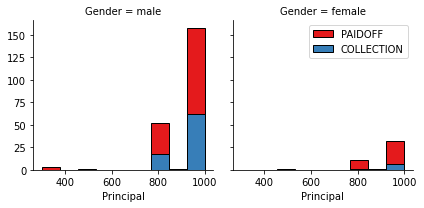

In [8]:
# Gender wise loan_status distribution in Pricipal Loan Amount
DrawGraph(df_Train.Principal.min(),df_Train.Principal.max(),'Principal',"Gender")

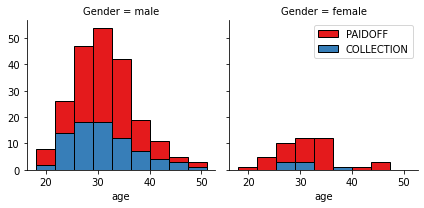

In [24]:
# Gender wise loan_status distribution in Age
DrawGraph(df_Train.age.min(),df_Train.age.max(),'age',"Gender")

We notice that males around 30 years with high principal amouts tend to go for collection. So would be an ideal to converet 'Gender' variable into numeric anduse in the classification

In [25]:
# see the distribution of gender wrt loan_status
df_Train.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

It is clear that almost 87% of female paid there loand while only 73% of males paid the loan.

**Visualize to explore the _gender_ wise _loan status_ wrt _effective_date_**

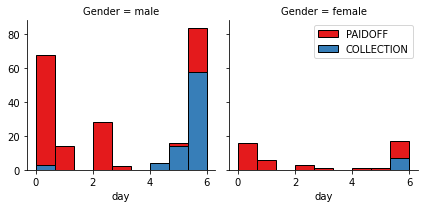

In [26]:
df_Train['day']=df_Train['effective_date'].dt.dayofweek
DrawGraph(df_Train.day.min(),df_Train.day.max(),'day','Gender')

Above graphs show that the people who get the loan towards the end of the week tend to not to pay. Let's create a binary varaiable to use effective_dat as a feature.

In [27]:
df_Train['Weekend']=df_Train['day'].apply(lambda x: 1 if (x>3) else 0)
df_Train.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,day,Weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


**Visualize to explore the _education_ wise _loan status_**

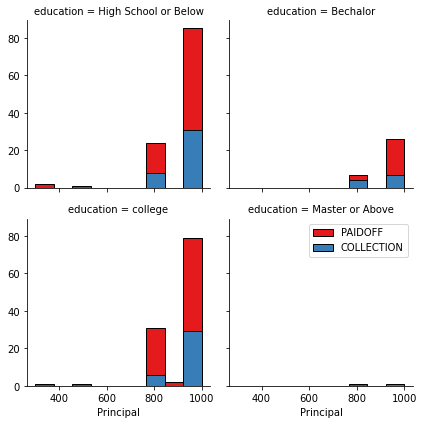

In [28]:
DrawGraph(df_Train.Principal.min(),df_Train.Principal.max(),'Principal','education')

In [29]:
df_Train.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Here we see no differentiation in _master or above_, then better cosidering remove it when it comes to feature selection.

**Pre-processing**

In [30]:
# convert Gender into a binary variable
df_Train['Gender'].replace(to_replace=['male','female'], value=[0,1], inplace=True)
df_Train.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,day,Weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


### One Hot Encoding and Feature Selection 

In [32]:
# get features from Training dataset
Features = df_Train[['Principal','terms','age','Gender','day']]
Features.head()

,Principal,terms,age,Gender,day
0,1000,30,45,0,3
1,1000,30,33,1,3
2,1000,15,27,0,3
3,1000,30,28,1,4
4,1000,30,29,0,4


**One Hot Encoding**

In [38]:
# adding education with one hot endocing
Features = pd.concat([Features, pd.get_dummies(df_Train['education'])], axis=1)
# remove master or above as discussed befoe
Features.drop(['Master or Above'], axis=1, inplace=True)

**Feature Selection**

In [37]:
# define feature set
X = Features
X[0:5]

,Principal,terms,age,Gender,day,Bechalor,High School or Below,college,Bechalor,High School or Below,college,Bechalor,High School or Below,college
0,1000,30,45,0,3,0,1,0,0,1,0,0,1,0
1,1000,30,33,1,3,1,0,0,1,0,0,1,0,0
2,1000,15,27,0,3,0,0,1,0,0,1,0,0,1
3,1000,30,28,1,4,0,0,1,0,0,1,0,0,1
4,1000,30,29,0,4,0,0,1,0,0,1,0,0,1


In [39]:
# respective labels
y = df_Train['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Normalize Data

In order to make the dataset with ro mean and unit variance, we need o standardize the selected features before using in the classification

In [41]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -0.26122054,
        -0.38170062,  1.13639374, -0.86968108, -0.38170062,  1.13639374,
        -0.86968108, -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -0.26122054,
         2.61985426, -0.87997669, -0.86968108,  2.61985426, -0.87997669,
        -0.86968108,  2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -0.26122054,
        -0.38170062, -0.87997669,  1.14984679, -0.38170062, -0.87997669,
         1.14984679, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.12175534,
        -0.38170062, -0.87997669,  1.14984679, -0.38170062, -0.87997669,
         1.14984679, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.12175534,
        -0.38170062, -0.87997669,  1.14984679, -0.38170062, -0.87997669,
         1.14984679, -0.38

## Classification 

To find the best classification model, we split training dataset into 2 parts, namely train dset and test set. We use train set to tarin the model and test set see the accuracy of each model to finalize the optimal solution.

**Train-Test Split**

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=4)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (276, 14) (276,)
Test set: (70, 14) (70,)


### K Nearest Neighbour (KNN)

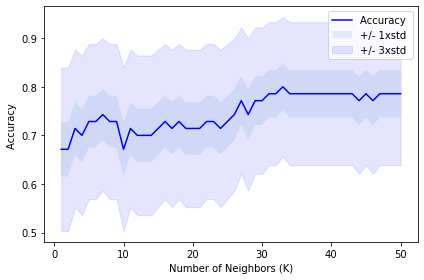

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

K=50
mean_accuracy = np.zeros((K))
std_accuracy = np.zeros((K))

for K in range(1,K+1):
    knn_model=KNeighborsClassifier(n_neighbors=K).fit(X_train,y_train)
    yHat = knn_model.predict(X_test)
    mean_accuracy[K-1]=metrics.accuracy_score(y_test, yHat)
    std_accuracy[K-1]=np.std(yHat==y_test)/np.sqrt(yHat.shape[0])
    
plt.plot(range(1,K+1), mean_accuracy, 'b')
plt.fill_between(range(1,K+1),mean_accuracy - 1 * std_accuracy , mean_accuracy + 1 * std_accuracy, alpha=0.10)
plt.fill_between(range(1,K+1),mean_accuracy - 3 * std_accuracy , mean_accuracy + 3 * std_accuracy, alpha=0.10 , color="blue")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [51]:
print('The best k to build the model is k =',np.argmax(mean_accuracy)+1,'with the accuracy', mean_accuracy.max().round(3))

The best k to build the model is k = 33 with the accuracy 0.8


In [53]:
# build the model using K=33
kNN_Model=KNeighborsClassifier(n_neighbors=33).fit(X_train,y_train)
kNN_Model

KNeighborsClassifier(n_neighbors=33)